## PROJECT 4. MasterMind. 
Gorlova Kristina

## Цель: 
Подготовить основу рекомендательной системы.

## Задачи:
1. Построить таблицу, в которой курсам будет соответствовать по две рекомендации.
2. Оформить и снабдить комментариями написанные в процессе скрипты.
3. Провести А/В тестирование и оценить его результат.

## Формализованные задачи:
1. Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
2. Обработать данные средствами Python.
3. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.
4. Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод.

Получив данные по пользователям и курсам, купленным 2 раза и более, приступаем к дальнейшему анализу для формулировки рекомендаций.

## Предварительная обработка

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import itertools
from itertools import chain
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# загружаем таблицу покупок
carts = pd.read_csv('P4_Таблица покупок.csv')
new_columns = ['user_id','course_id']
carts.columns = new_columns

In [3]:
# проверяем все ли курсы, предоставленные в базе данных SQL попали в таблицу покупок
carts_courses_id = carts['course_id'].to_list()
len(set(carts_courses_id))

126

In [4]:
# Обнаруживаем, что из 127 уникальных курсов, представленных в онлайн-школе в таблицу покупок попало 126
# это значит, что 1 курс не попал в исходные данные
all_corses = pd.read_csv('P4_Уникальные курсы.csv')
all_corses_list = all_corses['resource_id'].to_list()
len(all_corses_list)

127

In [5]:
# получаем и создаем лист с id курса, который не попал в исходные данные
lonely_course = set(all_corses_list) - set(carts_courses_id)
lonely_course_list = list(lonely_course)

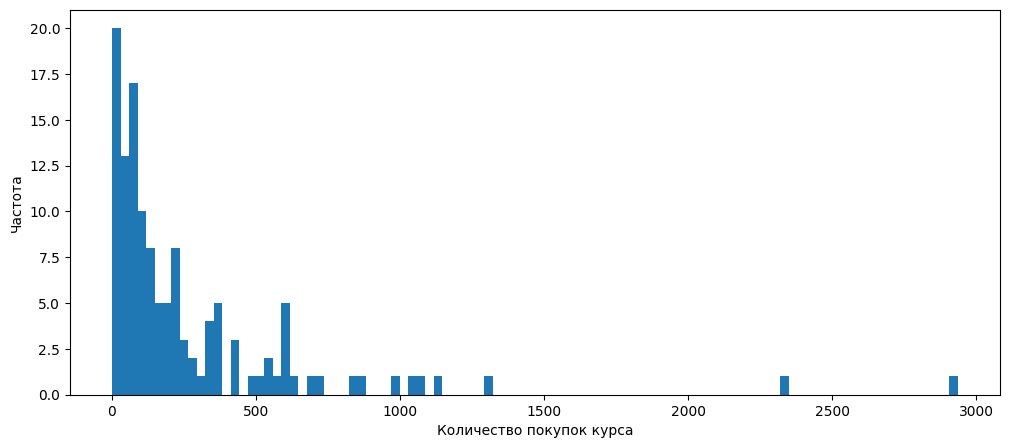

In [6]:
# для определения минимального количества покупок, от которого курс следует включать в рекомендации посмотрим гистограмму
# распределения частоты покупок курсов в определенном количестве
carts_groupped = carts.groupby('course_id')['user_id'].count()
fig, axes = plt.subplots(figsize=(12, 5))
plt.hist(carts_groupped, bins=100)
plt.xlabel('Количество покупок курса')
plt.ylabel('Частота')
plt.show()

In [7]:
# так как по гистограмме несовсем понятно, какое количество покупок считать значимым смотрим статистику группировки частоты покупок
carts_groupped.describe()

count     126.000000
mean      270.428571
std       404.128483
min         2.000000
25%        58.500000
50%       124.000000
75%       350.000000
max      2935.000000
Name: user_id, dtype: float64

Изначально, мне казалось, что нет необходимости установки минимального порога продаж курса для попадания в рекомендации, так как все курсы были куплены в комплексе хотя бы раз. Часть курсов покупались первыми, еще часть покупались вторыми хотя бы раз. Только 1 курс, не должен был попасть в рекомендации, а к нему мы бы рекомендовали самые популярные. В таком случае мы бы выстроили рекомендации на основании сочетаний курсов в покупках пользователей, а не только на количественном показателе.
Но раз по условиям задания необходимо установить минимальный порог, то по статистическим данным было принято решение отсечь курсы по первому квартилю, а вместо них рекомендовать наиболее покупаемые.

Первый квартиль как граница оптимальна по нескольким причинам:
1. В этом случае будет отсеивать 25% наименее популярных курсов, позволяя сосредоточиться на более востребованных и успешных продуктах.
2. Возможность сосредоточить рекомендации на курсах с более высоким количеством покупок, что снижает риск того, что клиенты будут разочарованы предложенными продуктами.
3. Гибкость при принятии решений о рекомендациях.

In [8]:
# получаем список курсов, которые не попадают в рекомендации и смотрим его длину
not_significant_courses = carts_groupped[carts_groupped<59].index.to_list()
not_significant_courses_full = not_significant_courses + lonely_course_list
display(len(not_significant_courses_full))

33

In [9]:
# получаем список курсов, которые попадают в рекомендации и смотрим его длину
significant_courses = carts_groupped[carts_groupped>58].index.to_list()
display(len(significant_courses))

94

In [10]:
# получаем таблицу покупок по курсам, которые попадают в рекомендации
carts_new = carts[carts['course_id'].isin(significant_courses)]

In [11]:
# группируем таблицу по user_id и собираем список course_id для каждого пользователя
user_courses = carts_new.groupby('user_id')['course_id'].agg(list).to_dict()

In [12]:
# создаем словарь со всеми возможными сочетаниями курсов для каждого пользователя
courses_combinations = {} 
for user_id, courses in user_courses.items():
    combinations = []
    for i in range(2, 3): # получаем комбнации из двух записей
        combinations += list(itertools.combinations(courses, i)) # получаем все возможные сочетания курсов заданной длины 
    courses_combinations[user_id] = combinations

In [13]:
# получаем список сочетаний курсов 
courses_combinations_list = list(courses_combinations.values())
# распаковываем списки внутри списка сочетаний курсов
courses_combinations_list_full = list(chain.from_iterable(courses_combinations_list))
# распаковываем список во множество, чтобы исключить повторы
courses_combinations_list_uniqe = set(courses_combinations_list_full)
len(courses_combinations_list_uniqe)

3059

In [14]:
# считаем при помощи счетчика сколько раз встречается каждая комбинация курсов
courses_combinations_counter = Counter(courses_combinations_list_full)
courses_combinations_counter.most_common(1) #сортируем

[((551, 566), 797)]

In [15]:
# получаем таблицу, в которой столбцы - это номера курсов и количество их покупок одним пользователем
courses_df = pd.DataFrame({'course_1': list(map(lambda x: x[0], courses_combinations_counter.keys())), 
                   'course_2': list(map(lambda x: x[1], courses_combinations_counter.keys())), 
                   'count': list(courses_combinations_counter.values())})

In [16]:
# получаем таблицу, в которой столбцы - это номера курсов и количество их покупок одним пользователем
courses_df_sorted = courses_df.sort_values('count', ascending = False, ignore_index=True).applymap(pd.to_numeric, errors='coerce')
# получаем сводную таблицу, в которой столбцы и индекс это номера курсов, а значение это количество их совместных покупок, получаем данные в виде таблицы
courses_df_sorted_max = courses_df_sorted.groupby(['course_2', 'course_1'])['count'].max().unstack()
# заменяем NaN на 0
courses_df_sorted_max_new = courses_df_sorted_max.fillna(0)

In [17]:
# создаем таблицу с рекомендациями по первым курсам
first_recommendation_table = pd.DataFrame(columns=['Course', 'First_recommendation', 'Second_recommendation'])
# Проходимся по каждому столбцу и находим два наиболее часто встречающихся значения
for col in courses_df_sorted_max_new.columns:
    s = courses_df_sorted_max_new[col].nlargest(2)
    First_recommendation = s.index[0]
    Second_recommendation = s.index[1]
        # Добавляем строку в новый датафрейм
    first_recommendation_table.loc[col] = [col, First_recommendation, Second_recommendation]

In [18]:
# удаляем индекс, дублирующий номер курса
first_recommendation_table.reset_index(drop= True , inplace= True )

In [19]:
first_recommendation_table.head(5)

,Course,First_recommendation,Second_recommendation
0,356,571,357
1,357,571,1125
2,358,570,752
3,361,551,1138
4,363,511,562


In [20]:
# проверяем, сколько курсов попали в данную таблицу с рекомендациями
len(first_recommendation_table.Course)

90

Видим, что 4 курса не хватает, значит они не попали в рекомендации. Скорее всего их не покупали первыми. Для того, чтобы получить рекомендации по ним, 
переворачиваем сводную таблицу без учета тех, что уже попали в рекомендации.

In [21]:
# для этого получаем список курсов, по которым уже подготовлены рекомендации из первой таблицы
first_recommendation_course_list = first_recommendation_table.Course.to_list()
# исключаем их из отсортированной таблицы и группируем в обратном порядке, получаем данные в виде таблицы
second_recommendation_table_max = courses_df_sorted[~courses_df_sorted['course_2'].isin(first_recommendation_course_list)].groupby(['course_1', 'course_2'])['count'].max().unstack()
# заменяем все NaN на 0
second_recommendation_table_max_new = second_recommendation_table_max.fillna(0)

In [22]:
# создаем таблицу с рекомендациями по курсам
second_recommendation_table = pd.DataFrame(columns=['Course', 'First_recommendation', 'Second_recommendation'])
# Проходимся по каждому столбцу и находим два наиболее часто встречающихся значения
for col in second_recommendation_table_max_new.columns:
    s = second_recommendation_table_max_new[col].nlargest(2)
    First_recommendation = s.index[0]
    Second_recommendation = s.index[1]
    
    # Добавляем строку в новый датафрейм
    second_recommendation_table.loc[col] = [col, First_recommendation, Second_recommendation]

In [23]:
# удаляем индекс, дублирующий номер курса
second_recommendation_table.reset_index(drop= True , inplace= True )

In [24]:
# смотрим, что в таблицу попали 4 оставшихся курса
second_recommendation_table.head()

,Course,First_recommendation,Second_recommendation
0,1152,551,490
1,1161,840,569
2,1184,752,507
3,1187,745,553


Как указывалось ранее, к остальным курсам будем рекомендовать наиболее популярные

In [25]:
# находим 2 самых популярных курса
carts_groupped.sort_values(ascending=False).head(2)

course_id
551    2935
566    2342
Name: user_id, dtype: int64

In [26]:
# создаем таблицу с рекомендацией для курсов, которые не попали список рекомендаций
not_significant_courses_table = pd.DataFrame(columns=['Course', 'First_recommendation', 'Second_recommendation'])
not_significant_courses_table['Course'] = not_significant_courses_full
not_significant_courses_table['First_recommendation'] = 551
not_significant_courses_table['Second_recommendation'] = 566

In [27]:
not_significant_courses_table.head()

,Course,First_recommendation,Second_recommendation
0,359,551,566
1,360,551,566
2,362,551,566
3,364,551,566
4,365,551,566


In [28]:
# Соединяем полученные таблицы
recommendation_table = pd.concat([first_recommendation_table, second_recommendation_table, not_significant_courses_table], ignore_index= True)

In [30]:
# выгружаем в Excel полученные рекомендации
recommendation_table.to_excel('Таблица с рекомендациями.xlsx')